<a href="https://colab.research.google.com/github/Chu-Yichen/QM2-Group-19/blob/main/MAIN_Data_Preparation%20%26%20Visualisation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Read and merge monitoring station information and filter sites in Atlanta by distance**

In [6]:
!pip install haversine folium

import pandas as pd
import numpy as np
import haversine
import requests
import folium
import matplotlib.pyplot as plt
import seaborn as sns
import math

monitors = pd.read_csv('https://aqs.epa.gov/aqsweb/airdata/aqs_monitors.zip', converters={'State Code': str, 'County Code': str, 'Site Number': str})
monitors['Site Id'] = monitors['State Code'] + '-' + monitors['County Code'] + '-' + monitors['Site Number']
# Creates a unique ID for each site
monitors = monitors[monitors['Parameter Code'].isin([81102, 88101, 44201, 42401, 42101, 42602])]
"""
Extracting monitors that contain our desired pollutants (PM10, PM2.5, Ozone, SO2, NO2, CO)
Ozone (O3 - ppm): 44201
PM2.5 (µg/m3): 88101
PM10 (µg/m3): 81102
CO (ppm): 42101
SO2 (ppb): 42401
NO2 (ppb): 42602
"""

monitors['First Year of Data'] = pd.to_numeric(monitors['First Year of Data'], errors='coerce')
monitors['Last Sample Date'] = pd.to_datetime(monitors['Last Sample Date'], errors='coerce')

# Extract the 'year' part of the Last Sample Date column
monitors['Last Year'] = monitors['Last Sample Date'].dt.year
monitors['Fist Year'] = monitors['First Year of Data']


"""
Counties in the Atlanta region (with their FIPS codes): https://atlantaregional.org/about-arc/about-the-atlanta-region/

Cherokee: 057
Clayton: 063
Cobb: 067
DeKalb: 089
Douglas: 097
Fayette: 113
Forsyth: 117
Fulton: 121
Gwinnett: 135
Henry: 151
Rockdale: 247
"""

# Filter the monitors, only leave those with 6 pollutants data available from 1999 to 2024.
atl_counties = ['057','063','067','089','097','113','117','121','135','151','247']
monitors = monitors[(monitors['State Code'] == '13') & (monitors['County Code'].isin(atl_counties))]


site_locations = monitors[['Site Id', 'Latitude', 'Longitude']]
# Filter the dataframe by Site ID and co-ordinates
site_locations = site_locations.drop_duplicates()
site_locations = site_locations.dropna()
# Creates unique rows for each site and removes any sites that do not contain Latitudes and Longitudes
site_locations = site_locations.set_index('Site Id')

def get_site_distances_km(site_locations, lat, lng):
    site_distances = {}
    for site_id, site_row in site_locations.iterrows():
        site_distances[site_id] = haversine.haversine((lat, lng), (site_row['Latitude'], site_row['Longitude']))
    return site_distances
# A function that finds the distance between inputted co-ordinates and each site. This returns a dictionary of site number and distance.

distances = get_site_distances_km(site_locations, 33.6324, -84.4333)
# Co-ordinates for Hartsfield-Jackson Atlanta International Airport into our function.

nearby_site_ids = [site_id for site_id, distance in distances.items() if distance < 15]
# This retrieves all of the site IDs within a 15km radius from the airport.
all_site_ids = set(site_locations.index.tolist()) - set(nearby_site_ids)
# All eligible sites in Atlanta, excluding those within a 15km radius.

# Print the results
print("Monitors within 15 km of Atlanta Airport:")
print(set(nearby_site_ids))
nearby_site_ids_lsit = list(nearby_site_ids)
print(monitors[monitors['Site Id'].isin(nearby_site_ids)][['Site Id', 'Parameter Code', 'Parameter Name', 'First Year of Data', 'Last Sample Date']].dropna().groupby(['Parameter Code', 'Parameter Name']).agg({'First Year of Data': 'min', 'Last Sample Date': 'max'}))

print("\nOther monitors within the specified counties and time range:")
print(set(all_site_ids))
all_site_ids_list = list(all_site_ids)
print(monitors[monitors['Site Id'].isin(all_site_ids)][['Site Id', 'Parameter Code', 'Parameter Name', 'First Year of Data', 'Last Sample Date']].dropna().groupby(['Parameter Code', 'Parameter Name']).agg({'First Year of Data': 'min', 'Last Sample Date': 'max'}))

<ipython-input-6-009f4ebe8824>:12: DtypeWarning: Columns (30) have mixed types. Specify dtype option on import or set low_memory=False.
  monitors = pd.read_csv('https://aqs.epa.gov/aqsweb/airdata/aqs_monitors.zip', converters={'State Code': str, 'County Code': str, 'Site Number': str})


Monitors within 15 km of Atlanta Airport:
{'13-121-0041', '13-121-0053', '13-121-0055', '13-121-0001', '13-121-1001', '13-121-0031', '13-121-0002', '13-089-0002', '13-121-0043', '13-121-4001', '13-121-0047', '13-121-5001', '13-121-5002', '13-063-0091'}
                                         First Year of Data Last Sample Date
Parameter Code Parameter Name                                               
42101          Carbon monoxide                       1972.0       2024-10-31
42401          Sulfur dioxide                        1962.0       2024-10-31
42602          Nitrogen dioxide (NO2)                1972.0       2024-08-31
44201          Ozone                                 1974.0       2024-08-31
81102          PM10 Total 0-10um STP                 1993.0       2024-09-30
88101          PM2.5 - Local Conditions              1999.0       2024-09-30

Other monitors within the specified counties and time range:
{'13-089-0003', '13-121-0048', '13-121-0051', '13-121-0042', '13-113-

<ipython-input-6-009f4ebe8824>:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  monitors['First Year of Data'] = pd.to_numeric(monitors['First Year of Data'], errors='coerce')
<ipython-input-6-009f4ebe8824>:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  monitors['Last Sample Date'] = pd.to_datetime(monitors['Last Sample Date'], errors='coerce')
<ipython-input-6-009f4ebe8824>:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_ind

# **Sites on the map**

In [20]:
import folium

# Define the coordinates of the airport
airport_lat, airport_lng = 33.6324, -84.4333

# Create a Folium map centered at the airport with an adjustable zoom level
m = folium.Map(location=[airport_lat, airport_lng], zoom_start=10)

# Draw a 15 km radius circle around the airport to represent the 'nearby' zone
folium.Circle(
    location=[airport_lat, airport_lng],  # Center of the circle (airport location)
    radius=15000,  # Radius in meters
    color='red',
    fill=False,
    popup='15 km Radius'  # Tooltip that appears when the circle is clicked
).add_to(m)

# Add markers for 'nearby' sites (within 15 km of the airport)
for site_id in nearby_site_ids_lsit:
    # Get latitude and longitude of the site
    lat = site_locations.loc[site_id, 'Latitude']
    lon = site_locations.loc[site_id, 'Longitude']

    # Add a red marker for the site with a popup showing its ID
    folium.Marker(
        location=[lat, lon],  # Site location
        icon=folium.Icon(color='red', icon='info-sign'),  # Red icon for nearby sites
        popup=f"Nearby site: {site_id}"  # Popup text showing the site ID
    ).add_to(m)

# Add markers for 'other' sites (beyond 15 km from the airport)
for site_id in all_site_ids_list:
    # Get latitude and longitude of the site
    lat = site_locations.loc[site_id, 'Latitude']
    lon = site_locations.loc[site_id, 'Longitude']

    # Add a blue marker for the site with a popup showing its ID
    folium.Marker(
        location=[lat, lon],  # Site location
        icon=folium.Icon(color='blue', icon='info-sign'),  # Blue icon for other sites
        popup=f"Other site: {site_id}"  # Popup text showing the site ID
    ).add_to(m)

# Display the map
m


# **Data Analysis for CO: (42101 Carbon Monoxide)**

Merge data

In [8]:
# For CO: Parameter Code 42101

years = range(1999, 2025)  # 1999 ~ 2024
urls = [f"https://aqs.epa.gov/aqsweb/airdata/daily_42101_{year}.zip" for year in years]

# our targeted sites = nearby + all
target_sites = nearby_site_ids_lsit + all_site_ids_list

all_data = []
for url in urls:
    df = pd.read_csv(url, compression='zip', low_memory=False)
    # Formatting
    df['State Code'] = df['State Code'].astype(str).str.zfill(2)
    df['County Code'] = df['County Code'].astype(str).str.zfill(3)
    df['Site Num'] = df['Site Num'].astype(str).str.zfill(4)
    df['Site Id'] = df['State Code'] + '-' + df['County Code'] + '-' + df['Site Num']
    df['Date Local'] = pd.to_datetime(df['Date Local'], errors='coerce')

    # Filter to only get the targeted sites
    df_target = df[df['Site Id'].isin(target_sites)]
    all_data.append(df_target)

# Merge each year's data
all_data = pd.concat(all_data, ignore_index=True)

# Extract the two sites' data respectively
df_nearby = all_data[all_data['Site Id'].isin(nearby_site_ids_lsit)].copy()
df_all = all_data[all_data['Site Id'].isin(all_site_ids_list)].copy()

# Extract daily data：in column 'Arithmetic Mean'

df_nearby_daily = df_nearby.groupby('Date Local')['Arithmetic Mean'].mean().reset_index(name='CO_mean_nearby')
df_all_daily = df_all.groupby('Date Local')['Arithmetic Mean'].mean().reset_index(name='CO_mean_all')



Visualisation: Daily Line Chart

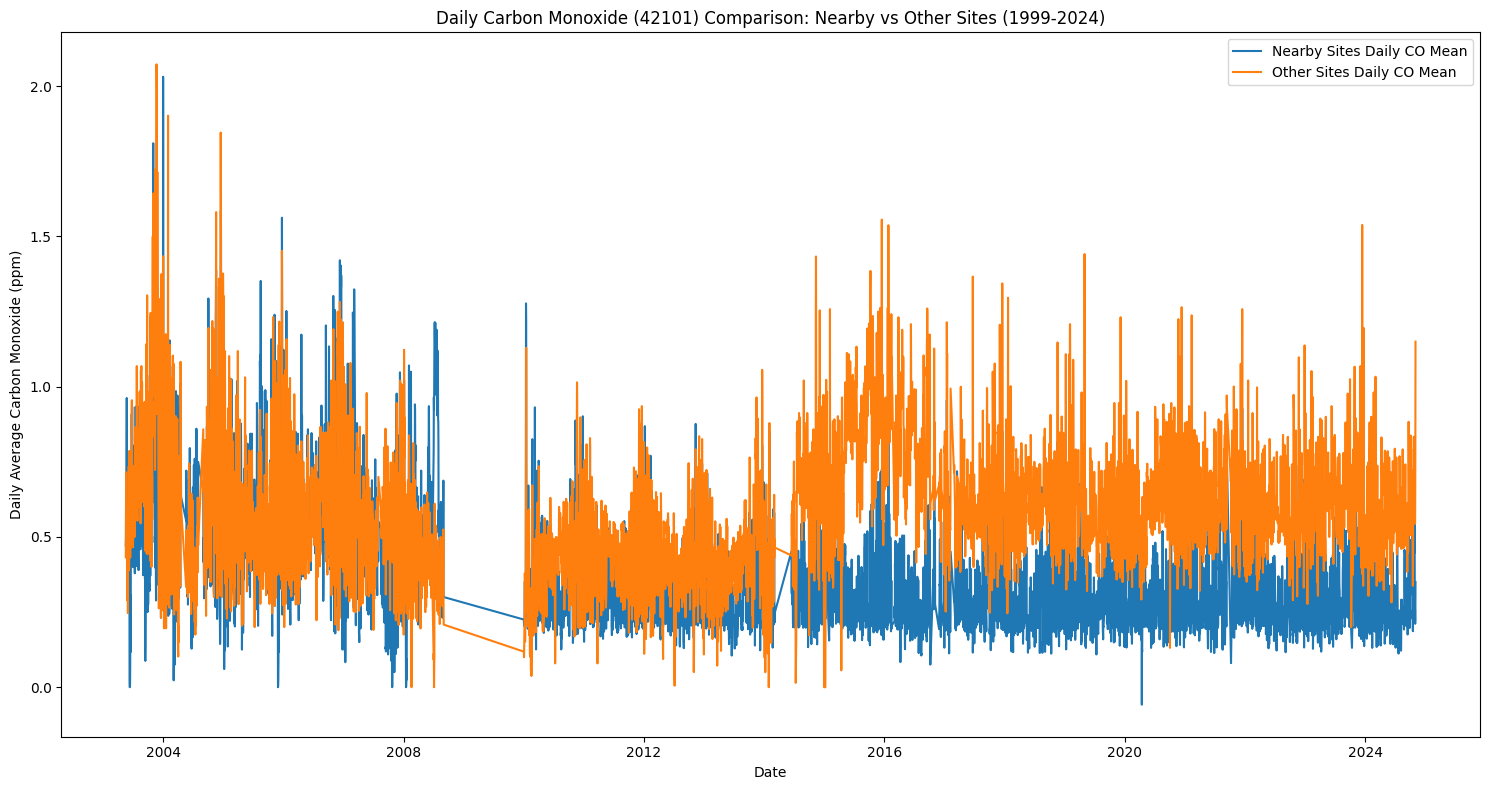

In [9]:
# Merge the two datasets to facilitate plotting
df_plot_daily = pd.merge(df_nearby_daily, df_all_daily, on='Date Local', how='inner')

plt.figure(figsize=(15,8))
sns.lineplot(x='Date Local', y='CO_mean_nearby', data=df_plot_daily, label='Nearby Sites Daily CO Mean')
sns.lineplot(x='Date Local', y='CO_mean_all', data=df_plot_daily, label='Other Sites Daily CO Mean')
plt.title('Daily Carbon Monoxide (42101) Comparison: Nearby vs Other Sites (1999-2024)')
plt.xlabel('Date')
plt.ylabel('Daily Average Carbon Monoxide (ppm)')
plt.legend()
plt.tight_layout()
plt.show()


Visualisation: Annual Line Chart

Annual mean for nearby sites:     year  CO_mean_nearby
0   2003        0.619581
1   2004        0.539882
2   2005        0.552392
3   2006        0.584739
4   2007        0.454229
5   2008        0.535013
6   2010        0.345722
7   2011        0.331725
8   2012        0.330369
9   2013        0.297181
10  2014        0.312784
11  2015        0.312534
12  2016        0.288075
13  2017        0.314071
14  2018        0.274388
15  2019        0.299879
16  2020        0.287023
17  2021        0.309095
18  2022        0.295341
19  2023        0.309950
20  2024        0.288543

Annual mean for other sites in Atlanta     year  CO_mean_all
0   1999     0.788291
1   2000     0.667080
2   2001     0.726662
3   2002     0.639245
4   2003     0.703118
5   2004     0.612018
6   2005     0.594946
7   2006     0.612632
8   2007     0.540168
9   2008     0.402264
10  2009     0.384094
11  2010     0.402237
12  2011     0.434499
13  2012     0.426481
14  2013     0.427839
15  2014     0.569084
16  20

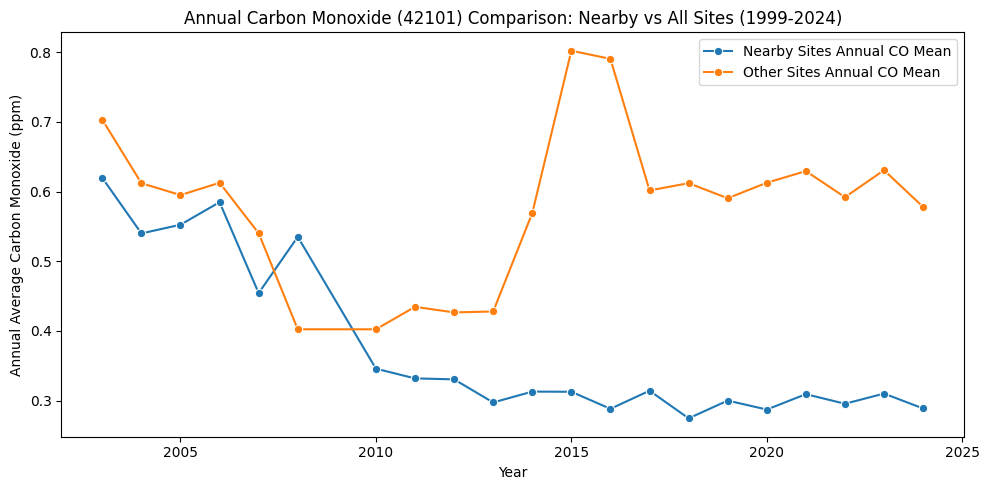

In [22]:
# Add a 'year' column to the daily data, extracting the year from the 'Date Local' column
df_nearby_daily['year'] = df_nearby_daily['Date Local'].dt.year
df_all_daily['year'] = df_all_daily['Date Local'].dt.year

# Group by 'year' and calculate the mean for each year
df_nearby_annual = df_nearby_daily.groupby('year')['CO_mean_nearby'].mean().reset_index()
df_all_annual = df_all_daily.groupby('year')['CO_mean_all'].mean().reset_index()


print("Annual mean for nearby sites:", df_nearby_annual)

print("\nAnnual mean for other sites in Atlanta", df_all_annual)

# Maybe looks a little bit messy but gives all the raw annual mean data

# Merge the two datasets on the 'year' column to facilitate plotting
df_plot_annual = pd.merge(df_nearby_annual, df_all_annual, on='year', how='inner')

# Create a line plot to compare the annual mean CO levels for nearby and other sites
plt.figure(figsize=(10, 5))
sns.lineplot(x='year', y='CO_mean_nearby', data=df_plot_annual, marker='o', label='Nearby Sites Annual CO Mean')
sns.lineplot(x='year', y='CO_mean_all', data=df_plot_annual, marker='o', label='Other Sites Annual CO Mean')


plt.title('Annual Carbon Monoxide (42101) Comparison: Nearby vs All Sites (1999-2024)')
plt.xlabel('Year')
plt.ylabel('Annual Average Carbon Monoxide (ppm)')


plt.legend()
plt.tight_layout()
plt.show()


More Visualisation (Box Plot, Violin Plot)

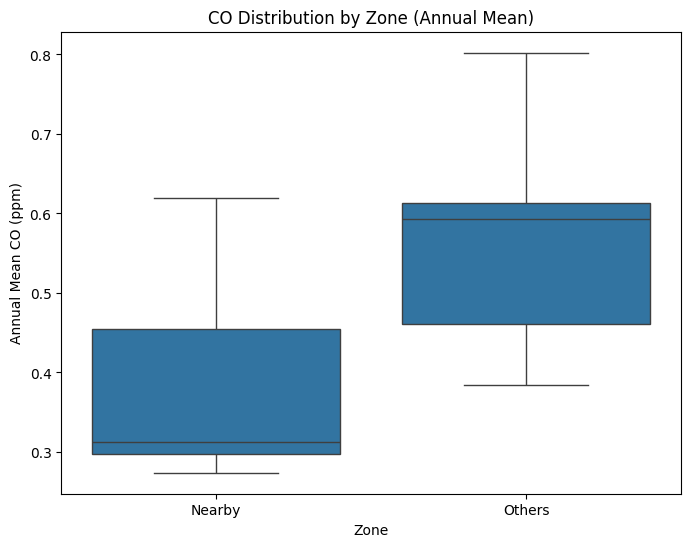

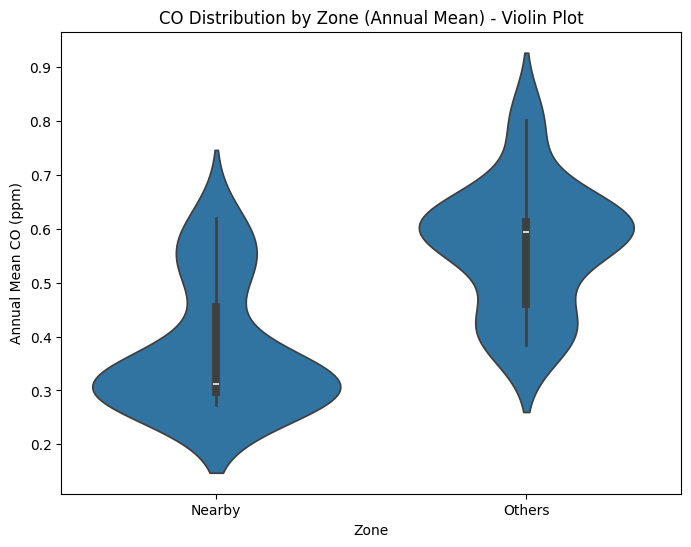

In [26]:
# Calculate annual mean CO for nearby sites
df_nearby_annual = df_nearby.copy()
df_nearby_annual['Year'] = df_nearby_annual['Date Local'].dt.year
df_nearby_annual = (
    df_nearby_annual.groupby('Year', as_index=False)['Arithmetic Mean']
    .mean()
    .rename(columns={'Arithmetic Mean': 'CO_annual_mean_nearby'})
)

# Calculate annual mean CO for all sites
df_all_annual = df_all.copy()
df_all_annual['Year'] = df_all_annual['Date Local'].dt.year
df_all_annual = (
    df_all_annual.groupby('Year', as_index=False)['Arithmetic Mean']
    .mean()
    .rename(columns={'Arithmetic Mean': 'CO_annual_mean_all'})
)

# Filter data for the years 2003 to 2024, as we don't get data from nearby sites before 2023
# REMOVE the filter dor other pollutants if they have enough data
df_nearby_annual = df_nearby_annual.loc[
    (df_nearby_annual['Year'] >= 2003) &
    (df_nearby_annual['Year'] <= 2024)
]
df_all_annual = df_all_annual.loc[
    (df_all_annual['Year'] >= 2003) &
    (df_all_annual['Year'] <= 2024)
]

# Prepare long-format data for visualization
df_nearby_long_annual = df_nearby_annual[['Year','CO_annual_mean_nearby']].rename(
    columns={'CO_annual_mean_nearby':'CO_annual_mean'}
)
df_nearby_long_annual['Zone'] = 'Nearby'

df_all_long_annual = df_all_annual[['Year','CO_annual_mean_all']].rename(
    columns={'CO_annual_mean_all':'CO_annual_mean'}
)
df_all_long_annual['Zone'] = 'Others'

# Combine nearby and all site data for visualization
df_annual_comparison = pd.concat([df_nearby_long_annual, df_all_long_annual], ignore_index=True)

# Create a box plot to compare annual mean CO distribution by zone
plt.figure(figsize=(8,6))
sns.boxplot(x='Zone', y='CO_annual_mean', data=df_annual_comparison)
plt.title('CO Distribution by Zone (Annual Mean)')
plt.ylabel('Annual Mean CO (ppm)')
plt.show()

# Create a violin plot to compare annual mean CO distribution by zone
plt.figure(figsize=(8,6))
sns.violinplot(x='Zone', y='CO_annual_mean', data=df_annual_comparison)
plt.title('CO Distribution by Zone (Annual Mean) - Violin Plot')
plt.ylabel('Annual Mean CO (ppm)')
plt.show()


Map & Graph : Spatial Analysis

In [23]:
!pip install basemap ipywidgets

from mpl_toolkits.basemap import Basemap  # For map visualization
import matplotlib.colors as mcolors  # For custom color scales
import ipywidgets as widgets  # For interactivity
from ipywidgets import interact  # For dynamic updates

# Add a 'Year' column to daily data
all_data['Year'] = all_data['Date Local'].dt.year

# Group data by 'Site Id' and 'Year', calculate annual average CO
df_siteyear = (
    all_data
    .groupby(['Site Id', 'Year'], as_index=False)['Arithmetic Mean']
    .mean()
    .rename(columns={'Arithmetic Mean': 'annual_CO'})
)

# Merge with site coordinates
site_locations_reset = site_locations.reset_index()
df_siteyear_merged = pd.merge(
    df_siteyear,
    site_locations_reset[['Site Id', 'Latitude', 'Longitude']],
    on='Site Id', how='inner'
)

# Clean data and define CO value range for color scaling
df_siteyear_merged.dropna(subset=['annual_CO', 'Latitude', 'Longitude'], inplace=True)
vmin, vmax = df_siteyear_merged['annual_CO'].min(), df_siteyear_merged['annual_CO'].max()

# Define custom color map (Green -> Yellow -> Red)
my_cmap = mcolors.LinearSegmentedColormap.from_list('CO_colormap', ['green', 'yellow', 'red'])

# Atlanta airport coordinates
airport_lat, airport_lng = 33.6367, -84.4281

# Function to plot map for a selected year
def plot_map_for_year(year):
    """Plot annual CO data for the given year."""
    df_year = df_siteyear_merged[df_siteyear_merged['Year'] == year]
    plt.figure(figsize=(8, 8))

    # Create Basemap focused on Atlanta
    m = Basemap(projection='lcc', resolution='l', lat_0=33.75, lon_0=-84.4, width=4e5, height=4e5)
    m.drawcoastlines(), m.drawcountries(), m.drawstates()

    # Mark airport location with a star
    x_airport, y_airport = m(airport_lng, airport_lat)
    m.plot(x_airport, y_airport, marker='*', color='black', markersize=14, label='ATL Airport')

    # Add 15 km radius circle
    m.tissot(airport_lng, airport_lat, 15 / 111.0, 100, facecolor='none', edgecolor='red', linewidth=2, alpha=0.8)

    # Plot CO levels for sites
    x, y = m(df_year['Longitude'].values, df_year['Latitude'].values)
    sc = m.scatter(x, y, c=df_year['annual_CO'], cmap=my_cmap, vmin=vmin, vmax=vmax, s=60, alpha=0.8, edgecolors='white', linewidths=0.5)

    # Add colorbar and title
    cbar = plt.colorbar(sc, orientation='vertical', shrink=0.7, pad=0.03)
    cbar.set_label('Annual Average CO (ppm)')
    plt.title(f"Annual CO in Atlanta Region - {year}")
    plt.legend(loc='lower left')
    plt.show()

# Create interactive dropdown for year selection
all_years = sorted(df_siteyear_merged['Year'].unique())
interact(
    plot_map_for_year,
    year=widgets.Dropdown(options=all_years, value=all_years[0], description='Select Year:')
)


interactive(children=(Dropdown(description='Select Year:', options=(1999, 2000, 2001, 2002, 2003, 2004, 2005, …

<function __main__.plot_map_for_year(year)>

# Data Analysis for NO2: (42602 Nitrogen Dioxide)

Merge data

In [ ]:
# For NO2: Parameter Code 42602

years = range(1999, 2025)  # 1999 ~ 2024
urls = [f"https://aqs.epa.gov/aqsweb/airdata/daily_42602_{year}.zip" for year in years]

# our targeted sites = nearby + all
target_sites = nearby_site_ids_lsit + all_site_ids_list

all_data = []
for url in urls:
    df = pd.read_csv(url, compression='zip', low_memory=False)
    # Formatting
    df['State Code'] = df['State Code'].astype(str).str.zfill(2)
    df['County Code'] = df['County Code'].astype(str).str.zfill(3)
    df['Site Num'] = df['Site Num'].astype(str).str.zfill(4)
    df['Site Id'] = df['State Code'] + '-' + df['County Code'] + '-' + df['Site Num']
    df['Date Local'] = pd.to_datetime(df['Date Local'], errors='coerce')

    # Filter to only get the targeted sites
    df_target = df[df['Site Id'].isin(target_sites)]
    all_data.append(df_target)

# Merge each year's data
all_data = pd.concat(all_data, ignore_index=True)

# Extract the two sites' data respectively
df_nearby = all_data[all_data['Site Id'].isin(nearby_site_ids_lsit)].copy()
df_all = all_data[all_data['Site Id'].isin(all_site_ids_list)].copy()

# Extract daily data：in column 'Arithmetic Mean'

df_nearby_daily = df_nearby.groupby('Date Local')['Arithmetic Mean'].mean().reset_index(name='NO2_mean_nearby')
df_all_daily = df_all.groupby('Date Local')['Arithmetic Mean'].mean().reset_index(name='NO2_mean_all')



Visualisation: Daily Line Chart

In [ ]:
# Merge the two datasets to facilitate plotting
df_plot_daily = pd.merge(df_nearby_daily, df_all_daily, on='Date Local', how='inner')

plt.figure(figsize=(15,8))
sns.lineplot(x='Date Local', y='NO2_mean_nearby', data=df_plot_daily, label='Nearby Sites Daily NO2 Mean')
sns.lineplot(x='Date Local', y='NO2_mean_all', data=df_plot_daily, label='Other Sites Daily NO2 Mean')
plt.title('Daily Nitrogen Dioxide (42602) Comparison: Nearby vs Other Sites (1999-2024)')
plt.xlabel('Date')
plt.ylabel('Daily Average Nitrogen Dioxide (ppb)')
plt.legend()
plt.tight_layout()
plt.show()


Visualisation: Annual Line Chart

In [ ]:
# Add a 'year' column to the daily data, extracting the year from the 'Date Local' column
df_nearby_daily['year'] = df_nearby_daily['Date Local'].dt.year
df_all_daily['year'] = df_all_daily['Date Local'].dt.year

# Group by 'year' and calculate the mean for each year
df_nearby_annual = df_nearby_daily.groupby('year')['NO2_mean_nearby'].mean().reset_index()
df_all_annual = df_all_daily.groupby('year')['NO2_mean_all'].mean().reset_index()


print("Annual mean for nearby sites:", df_nearby_annual)

print("\nAnnual mean for other sites in Atlanta", df_all_annual)

# Maybe looks a little bit messy but gives all the raw annual mean data

# Merge the two datasets on the 'year' column to facilitate plotting
df_plot_annual = pd.merge(df_nearby_annual, df_all_annual, on='year', how='inner')

# Create a line plot to compare the annual mean CO levels for nearby and other sites
plt.figure(figsize=(10, 5))
sns.lineplot(x='year', y='NO2_mean_nearby', data=df_plot_annual, marker='o', label='Nearby Sites Annual NO2 Mean')
sns.lineplot(x='year', y='NO2_mean_all', data=df_plot_annual, marker='o', label='Other Sites Annual NO2 Mean')


plt.title('Annual Nitrogen Dioxide (42602) Comparison: Nearby vs Other Sites (1999-2024)')
plt.xlabel('Year')
plt.ylabel('Annual Average Nitrogen Dioxide (ppb)')


plt.legend()
plt.tight_layout()
plt.show()


More Visualisation (Box Plot, Violin Plot)

In [ ]:
# Construct long-format data for visualization
df_nearby_long = df_nearby_daily[['Date Local', 'NO2_mean_nearby']].rename(columns={'NO2_mean_nearby': 'NO2_mean'})
df_nearby_long['Zone'] = 'Nearby'  # Label the 'Nearby' zone

df_all_long = df_all_daily[['Date Local', 'NO2_mean_all']].rename(columns={'NO2_mean_all': 'NO2_mean'})
df_all_long['Zone'] = 'Others'  # Label the 'Others' zone

# Combine the two datasets into one for comparison
df_daily_comparison = pd.concat([df_nearby_long, df_all_long], ignore_index=True)

# Create a box plot to compare the distribution of daily mean CO between the two zones
plt.figure(figsize=(8,6))
sns.boxplot(x='Zone', y='NO2_mean', data=df_daily_comparison)
plt.title('NO2 Distribution by Zone')  # Set the title for the box plot
plt.ylabel('Daily Mean NO2 (ppb)')  # Label the y-axis
plt.show()

# Create a violin plot to further visualize the distribution of daily mean CO
plt.figure(figsize=(8,6))
sns.violinplot(x='Zone', y='NO2_mean', data=df_daily_comparison)
plt.title('NO2 Distribution by Zone (Violin Plot)')  # Set the title for the violin plot
plt.ylabel('Daily Mean NO2 (ppb)')  # Label the y-axis
plt.show()


Map & Graph: Spacial Data Analysis

In [ ]:
!pip install basemap ipywidgets

from mpl_toolkits.basemap import Basemap
import matplotlib.colors as mcolors


import ipywidgets as widgets
from ipywidgets import interact


# Example: all_data should include at least the following columns:
# ['Site Id', 'Date Local', 'Arithmetic Mean', ...]

# Ensure 'Date Local' is in datetime format
all_data['Year'] = all_data['Date Local'].dt.year

# Group by Site Id and Year, then calculate the mean
df_siteyear = (
    all_data
    .groupby(['Site Id','Year'], as_index=False)['Arithmetic Mean']
    .mean()
    .rename(columns={'Arithmetic Mean':'annual_NO2'})
)

# Merge with site_locations to include Latitude and Longitude
site_locations_reset = site_locations.reset_index()  # ['Site Id','Latitude','Longitude']
df_siteyear_merged = pd.merge(
    df_siteyear,
    site_locations_reset[['Site Id','Latitude','Longitude']],
    on='Site Id',
    how='inner'
)

# Remove invalid records
df_siteyear_merged.dropna(subset=['annual_NO2','Latitude','Longitude'], inplace=True)

# Define the global color scale range for uniform visualization
vmin = df_siteyear_merged['annual_NO2'].min()
vmax = df_siteyear_merged['annual_NO2'].max()

# Create a custom color map (Green -> Yellow -> Red)
my_cmap = mcolors.LinearSegmentedColormap.from_list(
    'NO2_colormap',
    ['green','yellow','red']
)

# ATL airport coordinates
airport_lat, airport_lng = 33.6367, -84.4281


# (2) Function to plot the map for a specific year

def plot_map_for_year(year):
    """Plot the annual average CO data for a specific year on a Basemap."""
    df_year = df_siteyear_merged[df_siteyear_merged['Year'] == year]

    plt.figure(figsize=(8,8))

    # Create the Basemap with Lambert Conformal projection
    m = Basemap(
        projection='lcc',
        resolution='l',
        lat_0=33.75,      # Center the map near ATL
        lon_0=-84.4,
        width=4e5,
        height=4e5
    )

    # Draw map boundaries and features
    m.drawcoastlines(color='black')
    m.drawcountries(color='black')
    m.drawstates(color='gray')

    # Mark the ATL airport with a star
    x_airport, y_airport = m(airport_lng, airport_lat)
    m.plot(
        x_airport, y_airport,
        marker='*',
        color='black',
        markersize=14,
        label='ATL Airport'
    )

    # Scatter plot for the CO data points of the selected year
    x, y = m(df_year['Longitude'].values, df_year['Latitude'].values)
    sc = m.scatter(
        x, y,
        c=df_year['annual_NO2'],
        cmap=my_cmap,
        vmin=vmin,
        vmax=vmax,
        s=60,
        alpha=0.8,
        edgecolors='white',
        linewidths=0.5
    )

    # Add a colorbar
    cbar = plt.colorbar(sc, orientation='vertical', shrink=0.7, pad=0.03)
    cbar.set_label('Annual Average NO2 (ppb)', fontsize=12)

    # Add title and legend
    plt.title(f"Annual NO2 in Atlanta Region - {year}", fontsize=14)
    plt.legend(loc='lower left')
    plt.show()


# (3) Interactive year selection

all_years = sorted(df_siteyear_merged['Year'].unique())

# Use interact for year selection
interact(
    plot_map_for_year,
    year=widgets.Dropdown(
        options=all_years,
        value=all_years[0],
        description='Select Year:'
    )
)
